In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
x_train = np.loadtxt('x_train.gz')
x_test = np.loadtxt('x_test.gz')
y_train = np.loadtxt('y_train.gz')
y_test = np.loadtxt('y_test.gz')

In [3]:
pca = PCA(n_components=350)

pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [4]:
# Class for KNN Model
class KNN:
    # Initialization Function for KNN Model
    def __init__ (self, K=1):
        self.K = K
    # Fit function for KNN model
    def fit(self,x_train,y_train):
        self.x_train = x_train
        self.y_train = y_train
    # Predict Function using Semi Vetorization
    def predict_semi(self, x_test):
        # Get test and training data in required form
        test = x_test.T
        train = self.x_train.T

        # initiate the distance matrix
        dists = np.empty((test.shape[1],train.shape[1]), dtype=np.float32)

        # Use semi vectorization to compute distance for distance matrix
        for j in range(train.shape[1]):
          diffs = test - train[:, j:(j+1)]
          diffs_sq = diffs*diffs
          dists_sq = diffs_sq.sum(axis=0)  # sum over the size-N axis
          dists[:,j] = np.sqrt(dists_sq)

        # initialize and calculate predictions for the KNN model
        predictions = []
        self.dists = dists
        for i in range(dists.shape[0]):
            idx = np.argpartition(dists[i],self.K)
            clas, freq = np.unique(self.y_train[idx[:self.K]], return_counts=True)
            predictions.append(clas[np.argmax(freq)])
        
        # return Predicted classes coresponding to each test vector
        self.predictions = predictions
        return predictions
    # Predict Function using Full Vectorization
    def predict_full(self, x_test):
        # get data in required fromat
        test = x_test.T[:,:,None]
        train = self.x_train.T[:,None,:]

        # Calulate the Distance matrix
        diffs = test - train
        diffs_sq = diffs**2
        dists_sq = diffs_sq.sum(axis=0) # sum over the size-N axis
        dists = np.sqrt(dists_sq)

        # initialize and calculate predictions for the KNN model
        predictions = []
        for i in range(dists.shape[0]):
            idx = np.argpartition(dists[i],self.K)
            clas, freq = np.unique(self.y_train[idx[:self.K]], return_counts=True)
            predictions.append(clas[np.argmax(freq)])
        self.predictions = predictions

        # return Predicted classes coresponding to each test vector
        return predictions
    # Predict function using element wise calculation
    def predict(self, x_test):
        # Initialize the predictions list
        predictions = []

        # taking one image at a time, calculate distance and corresponding prediction
        for image in x_test:
            distances = [np.sqrt(np.sum((image-self.x_train[i])**2)) for i in range(self.x_train.shape[0])]
            idx = np.argpartition(distances,self.K)
            clas, freq = np.unique(self.y_train[idx[:self.K]], return_counts=True)
            predictions.append(clas[np.argmax(freq)])
        self.predictions = predictions

        # return Predicted classes coresponding to each test vector
        return predictions
    # Predict function using element wise calculation for one image (for test purposes)
    def predictone(self, X):
        # Calculate the distance for KNN model
        distances = [np.sqrt(np.sum((X-self.x_train[i])**2)) for i in range(self.x_train.shape[0])]
        
        # Predict the class of the image
        idx = np.argpartition(distances,self.K)
        clas, freq = np.unique(self.y_train[idx[:self.K]], return_counts=True)

        # return Predicted class coresponding to test vector
        return clas[np.argmax(freq)]
    # Fuction to find the incorrectly categorized images (a replacement of confusion matrix for internal testing)
    def error_vals(self,y_test):
        # make a list of incorrectly identified test points and return them
        errors = [(self.predictions[i],y_test[i]) for i in range(len(y_test)) if self.predictions[i] != y_test[i]]
        return ([('prediction','y_val')] + errors)
    # Function for plotting Decision Boundary in 2 Dimensions
    def plot(self):
        # Calculate the min and max value for each dimension
        x_min, x_max = self.x_train[:, 0].min() - 100, self.x_train[:, 0].max() + 100
        y_min, y_max = self.x_train[:, 1].min() - 100, self.x_train[:, 1].max() + 100

        # Create a meshgrid using min and max values 
        # with intervals optimized for performance and fineness of boundary
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 25),np.arange(y_min, y_max, 25))

        # Predictions to obtain the classification results
        Z = np.array(self.predict_semi(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

        # colour parameter labeling 0 as red and 1 as blue
        col = ['b' if self.y_train[i] == 1 else 'r' for i in range(len(self.y_train))]

        # Plotting of the boundary
        plt.contourf(xx, yy, Z,colors =col, alpha=0.3)
        plt.scatter(self.x_train[:, 0], self.x_train[:, 1], c=col, alpha=0.6, s=1)
        plt.xlabel("Feature-1")
        plt.ylabel("Feature-2")

        # return the plt function to ease making customizations before plotting
        return plt

In [13]:
# Function to calculate the Prediction error using predictions and expected classification
def prediction_accu(prediction, y_test):
    if len(prediction) != len(y_test):
        print("you are trying to get prediction of lists of unequal size")
        return 0
    errors = sum([0 if prediction[i] != y_test[i] else 1 for i in range(len(y_test))])
    return (errors/len(y_test))*100

In [6]:
# Function to calculate the confusion matrix using expected and predicted results
def confusion_matrix(y_pred,y_test):
    cm = np.empty([np.unique(y_test).shape[0],np.unique(y_test).shape[0]], dtype=int)
    for cat in np.unique(y_test):
        idx = (y_test==np.unique(y_test)[cat])
        pred_event = np.array(y_pred)[idx]

        cm[cat,1] = sum(pred_event)
        cm[cat,0] = pred_event.shape[0] - cm[cat,1]
    return cm

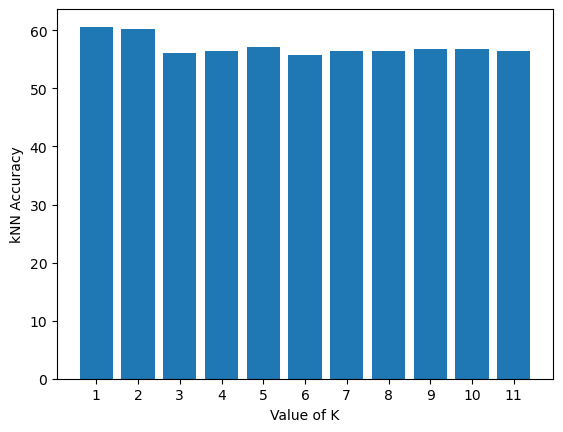

In [14]:
accus = []
k_vals = list(range(1,12))

for k in k_vals:
  model = KNN(K = k)
  model.fit(x_train, y_train)
  pred = model.predict_semi(x_test)
  accu = prediction_accu(pred,y_test)
  accus.append(accu)

plt.bar(k_vals, accus)
plt.xlabel('Value of K')
plt.ylabel('kNN Accuracy')
plt.xticks(range(1,12))
plt.show()

In [15]:
accus

[60.61643835616438,
 60.273972602739725,
 56.16438356164384,
 56.5068493150685,
 57.1917808219178,
 55.821917808219176,
 56.5068493150685,
 56.5068493150685,
 56.849315068493155,
 56.849315068493155,
 56.5068493150685]

In [16]:
model = KNN(K = 1)
model.fit(x_train, y_train)
pred = model.predict_semi(x_test)
accu = prediction_accu(pred,y_test)

In [17]:
accu

60.61643835616438